In [1]:
import pandas as pd
from datetime import date
from pathlib import Path
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.ticker as ticker
import random
import numpy as np

import opinionated  # noqa
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps
import seaborn as sns

CITY_SHORTCODE_NAME_LUT = {
    "AA": "Ann Arbor",
    "RO": "Royal Oak",
    "AP": "Alpena",
    "CS": "Cedar Springs",
    "GA": "Garden City",
    "IN": "Inkster",
    "JS": "Jackson",
    "LS": "Lansing",
    "LV": "Lathrup Village",
    "LN": "Livonia",
    "MH": "Madison Heights",
    "MT": "Manistee",
    "MP": "Memphis",
    "MC": "Mt Clemens",
    "PE": "Perry",
    "PR": "Pleasant Ridge",
    "RM": "Richmond",
    "SL": "Saline",
    "SC": "St Clair",
    "SH": "Sterling Heights",
    "WT": "Williamston",
    "SEA": "Seattle",
    "OAK": "Oakland",
}

CITIES_OF_INTEREST = [
    "AA",
    "RO",
    "JS",
    "LS",
    "SEA",
    "OAK",
]

ANNOTATIONS_DIR = Path("../data/annotated-for-modeling/").resolve()

/Users/evamaxfield/micromamba/envs/cdp-pc-seg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# Get the bold color map values
PALETTE_BOLD = cmaps.bold._colors
sns.set_palette(PALETTE_BOLD)

In [3]:
# Store all data to single object
data_dfs = []

def split_short_name_to_city_and_date(short_name: str) -> tuple[str, date]:
    # Split the short name into city and date
    short_code_and_date_parts = short_name.split("_")
    
    # Short code is the first part
    short_code = short_code_and_date_parts[0]

    # Date is the rest in month day two-digit-year format
    event_date = date(
        year=int("20" + short_code_and_date_parts[-1]),
        month=int(short_code_and_date_parts[1]),
        day=int(short_code_and_date_parts[2]),
    )

    return short_code, event_date

# Read all data
for filepath in ANNOTATIONS_DIR.glob("*.csv"):
    # Read the comment data
    df = pd.read_csv(filepath)

    # Lowercase all columns
    df.columns = df.columns.str.lower()

    # Remove any spaces from column names and replace with "_"
    df.columns = df.columns.str.replace(" ", "_")

    # Split the "name" column into "city_short_code" and "date"
    df["city_short_code"], df["date"] = zip(
        *df["name"].apply(split_short_name_to_city_and_date),
        strict=True,
    )

    # Add the city name
    df["city_name"] = df["city_short_code"].map(CITY_SHORTCODE_NAME_LUT)

    # Add a year-month column
    df["year_month"] = df["date"].apply(lambda x: x.replace(day=1))

    # Using the filename, mark if this was a "training" or "inferred" dataset
    df["dataset_portion"] = "training" if "truth" in filepath.stem else "inferred"

    # Add the truth data to the list
    data_dfs.append(df)

# Concatenate all training data
full_data = pd.concat(data_dfs)

# Subset the data to only the columns we care about
full_data = full_data[[
    "city_short_code",
    "city_name",
    "date",
    "year_month",
    "dataset_portion",
    "meeting_section",
    "speaker_role",
    "start",
    "end",
    "text",
]]

full_data.sample(3)

,city_short_code,city_name,date,year_month,dataset_portion,meeting_section,speaker_role,start,end,text
793,RO,Royal Oak,2023-02-27,2023-02-01,training,Public Hearing,Commenter,8296.205,8421.198,"That's pretty much the standard, and the house..."
691,AP,Alpena,2023-02-06,2023-02-01,training,Other,Other,6068.000,6076.909,Thank you. I move we adjourn to closed session...
848,RO,Royal Oak,2023-02-27,2023-02-01,training,Other,Other,9677.976,9717.506,We should also point out that just like we app...


In [4]:
# Filter to only the cities of interest
full_data = full_data[full_data["city_short_code"].isin(CITIES_OF_INTEREST)]

# Filter out government comments and only use public comment not hearing
meeting_comments = full_data[
    (full_data["meeting_section"] == "Public Comment")
    & (full_data["speaker_role"] == "Commenter")
]

meeting_comments.shape

(1637, 10)

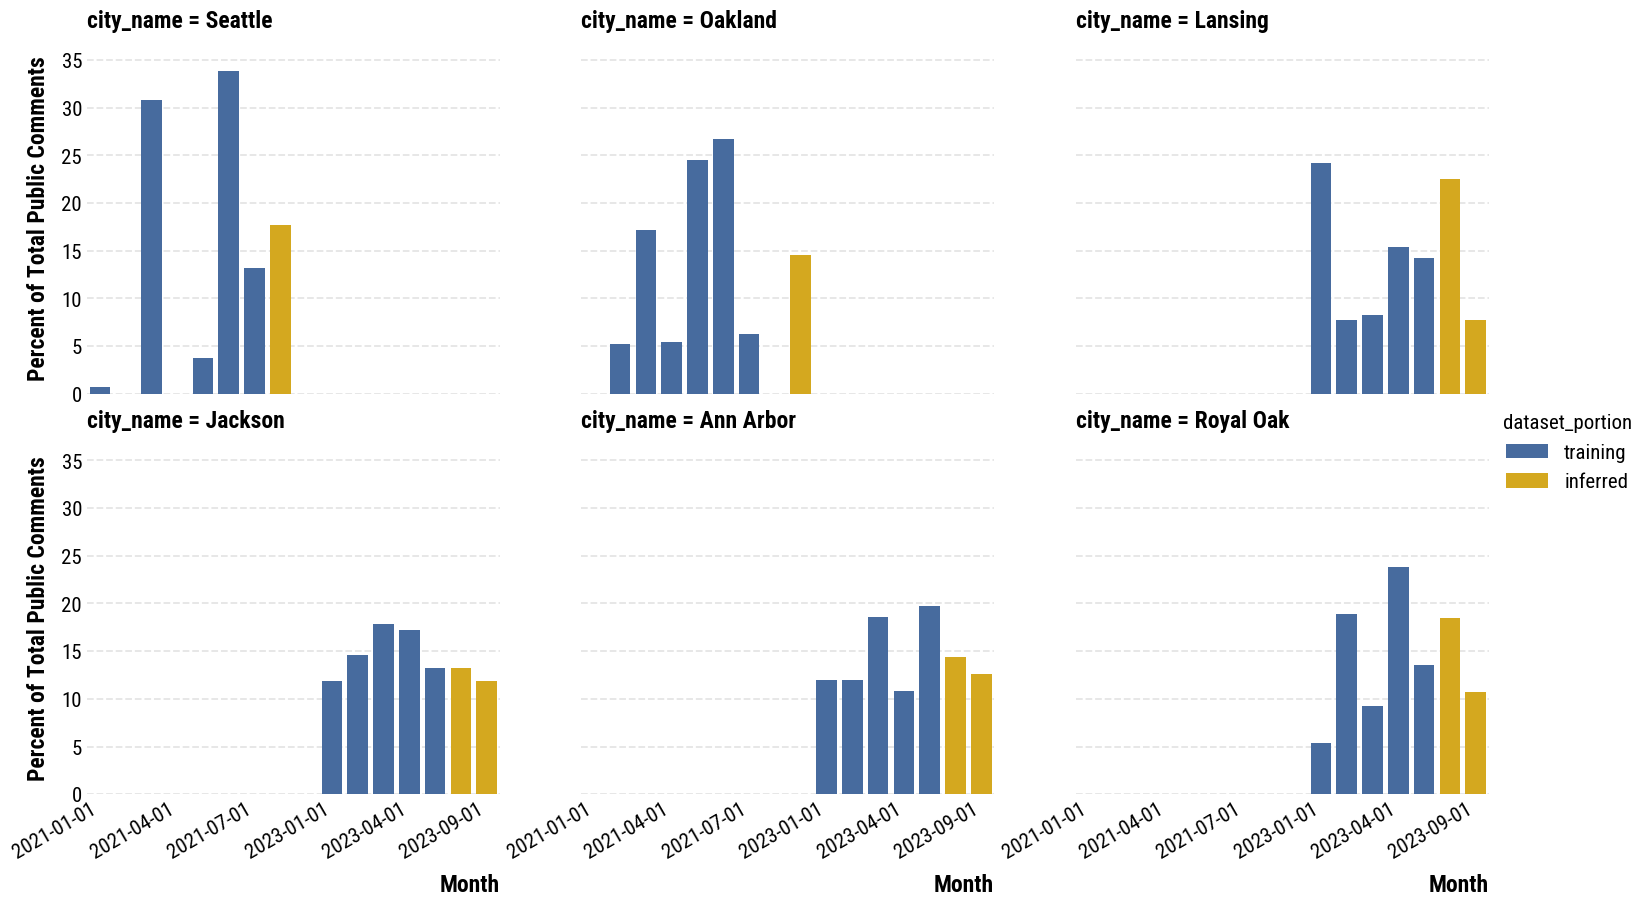

In [5]:
# Get the percent of comments by city (per month)
# i.e. how much of the training or inferred data comes from this month

# First get the total number of comments per city
city_comment_counts = meeting_comments["city_name"].value_counts()

# Get the total number of comments per city per month
city_month_comment_counts = meeting_comments.groupby(["city_name", "year_month"]).size()

# Iter rows and calculate the percent
percent_comments = []
for _, row in meeting_comments.iterrows():
    this_city_total_comments = city_comment_counts[row["city_name"]]
    this_city_month_total_comments = city_month_comment_counts[row["city_name"], row["year_month"]]
    percent = (this_city_month_total_comments / this_city_total_comments) * 100
    percent_comments.append({
        "city_name": row["city_name"],
        "year_month": row["year_month"].isoformat(),
        "percent_of_comments": percent,
        "dataset_portion": row["dataset_portion"],
    })

# Convert to a DataFrame
percent_comments_df = pd.DataFrame(percent_comments).sort_values("year_month", ignore_index=True)

# Col by city
g = sns.catplot(
    data=percent_comments_df,
    x="year_month",
    y="percent_of_comments",
    hue="dataset_portion",
    col="city_name",
    col_wrap=3,
    kind="bar",
    palette=PALETTE_BOLD[2:],
)

# Update the x-axis, and y-axis labels
g.set_axis_labels("Month", "Percent of Total Public Comments")
g.figure.autofmt_xdate()

# For each ax in the figure, set the x-axis locator to max 8 ticks
for ax in g.axes:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6))

In [6]:
# Set random state
random.seed(0)
np.random.seed(0)

# Init topic model and pipeline components
cluster_model = MiniBatchKMeans(n_clusters=30, random_state=0)
vectorizer_model = TfidfVectorizer(stop_words="english", max_df=30,min_df=3, lowercase=True)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)
umap_model = PCA(n_components=10)

topic_model = BERTopic(umap_model=umap_model,
                       hdbscan_model=cluster_model,
                       ctfidf_model=ctfidf_model,
                       vectorizer_model=vectorizer_model)

In [7]:
# Fit transform all data
topics, _ = topic_model.fit_transform(meeting_comments.text)

# Store topics in the dataframe
meeting_comments["topic_id"] = topics

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
# Get topic info and manually write topic names
topic_info = topic_model.get_topic_info()

# Print each topic and their representative docs
for _, row in topic_info.iterrows():
    print(f"Topic Id: {row['Topic']}")
    print(f"Short representation: {row['Representation']}")
    for doc in row["Representative_Docs"][:5]:
        print(f"\tExample Doc: {doc}")
    
    print("\n" + "="*80 + "\n")

Topic Id: 0
Short representation: ['macro', 'violence', 'police', 'prevention', 'opd', 'oakland', 'oaklanders', 'safety', 'reimagining', 'budget']
	Example Doc: Good afternoon, my name is Daniel Ruelo. I live in District 3. I'm calling to support immediately implementing MACRO and putting the fire department, not police, in charge of crisis calls. A mental health or other crisis should not be a death sentence, yet that's what happened to Joshua Pollack and Marcellus Toney in Oakland in just the past couple of years. We need to bring MACRO in-house in the fire department, staffed by trained city workers, union workers who have experience working with communities suffering from mental health crises, state violence, addiction, and domestic violence.  Critically, MACRO must be set up with direction from a community advisory board led by folks with expertise providing mental health support to these same communities. The only way we can ensure that MACRO will truly reimagine public safety is

In [9]:
# Create topic_id to topic_name mapping
topic_id_to_name_lut = {
    0: "Police Reform",
    1: "Undefined",
    2: "Housing and Homelessness",  # Eviction and renters rights
    3: "Arts and Programs",
    4: "Capital Investment",  # investment in a basketball coliseum
    5: "Israel-Palistine",
    6: "Undefined",
    7: "Budget and Finance",  # Pandemic recovery
    8: "Police Reform",  # Oak
    9: "Police Reform",  # Sea
    10: "Community Events",
    11: "Transportation and Infrastructure",
    12: "Planning and Zoning",
    13: "Transportation and Infrastructure",
    14: "Undefined",
    15: "Undefined",
    16: "Budget and Finance",
    17: "Public Services",  # Disability Services and Libraries?
    18: "Ethics and Accountability",
    19: "Utilities",
    20: "Police and Public Safety",
    21: "Transportation and Infrastructure",
    22: "Housing and Homelessness",
    23: "Housing and Homelessness",  # Eviction and renters rights
    24: "Housing and Homelessness",  # Fair chance housing
    25: "Budget and Finance",
    26: "Undefined",
    27: "Police Reform",  # Non-police emergency response
    28: "Public Services",
    29: "Housing and Homelessness",
}

# Map the topic names to the dataframe
meeting_comments["topic_name"] = meeting_comments["topic_id"].map(topic_id_to_name_lut)
meeting_comments.topic_name.value_counts()

Undefined                            312
Police Reform                        273
Housing and Homelessness             244
Transportation and Infrastructure    143
Budget and Finance                   142
Arts and Programs                     84
Public Services                       75
Capital Investment                    68
Israel-Palistine                      63
Community Events                      55
Planning and Zoning                   50
Utilities                             43
Ethics and Accountability             43
Police and Public Safety              42
Name: topic_name, dtype: int64

In [10]:
# Filter out all undefined topics
plotting_comments = meeting_comments[meeting_comments["topic_name"] != "Undefined"]

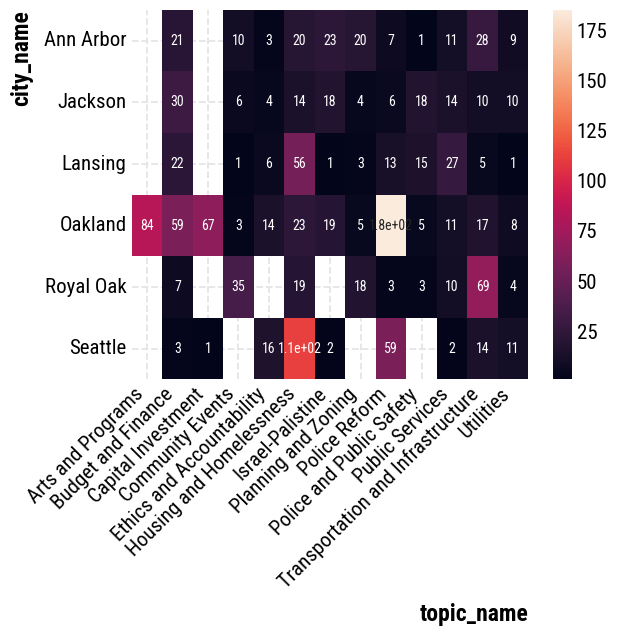

In [11]:
# Create topic name and city count dataframe
topic_city_counts = plotting_comments.groupby(["city_name", "topic_name"]).size().reset_index(name="comment_count")

# Convert to percentage and store in new frame
topic_city_counts["comment_pct"] = topic_city_counts.groupby("city_name")["comment_count"].transform(lambda x: x / x.sum())

# Heatmap of topic count per month per city
sns.heatmap(
    data=topic_city_counts.pivot(index="city_name", columns="topic_name", values="comment_count"),
    annot=True,
)
_ = plt.xticks(rotation=45, ha="right")

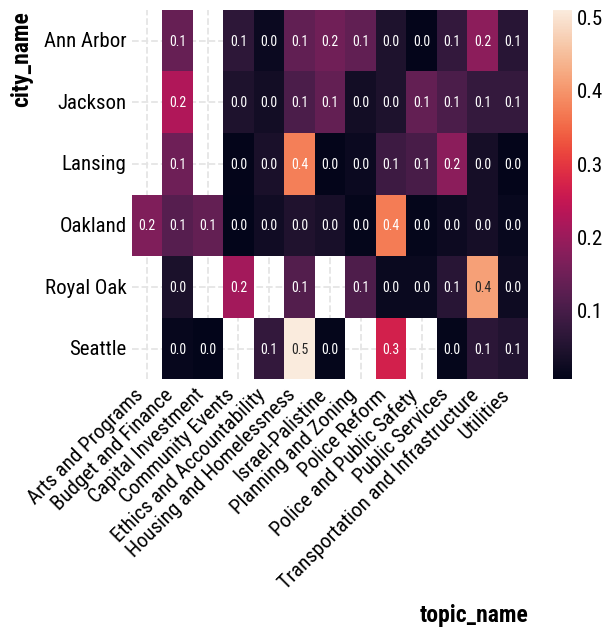

In [12]:
# Heatmap of topic percentage per month per city
sns.heatmap(
    data=topic_city_counts.pivot(index="city_name", columns="topic_name", values="comment_pct"),
    annot=True,
    fmt=".1f",
)
_ = plt.xticks(rotation=45, ha="right")

- line plot / scatter of percent comments in training vs precision (or f1)

In [18]:
from scipy.stats import entropy

# LM plot with F1 of model + number of comments
city_name_f1_lut = {
    "Ann Arbor": 0.854,
    "Royal Oak": 0.781,
    "Jackson": 0.789,
}

# Create dataframe of city_name, f1, comment_count, and entropy(topic_percents)
city_f1_entropy_df = []
for city_name, city_df in topic_city_counts.groupby("city_name"):
    if city_name not in city_name_f1_lut:
        continue

    # Get the f1
    f1 = city_name_f1_lut[city_name]

    # Get the comment count
    comment_count = city_df["comment_count"].sum()

    # Get the entropy
    topic_percents = city_df["comment_pct"].values
    entropy_val = entropy(topic_percents)

    city_f1_entropy_df.append({
        "city_name": city_name,
        "model_f1": f1,
        "comment_count": comment_count,
        "topic_entropy": entropy_val,
    })

city_f1_entropy_df = pd.DataFrame(city_f1_entropy_df)
city_f1_entropy_df


,city_name,model_f1,comment_count,topic_entropy
0,Ann Arbor,0.854,153,2.185488
1,Jackson,0.789,134,2.221526
2,Royal Oak,0.781,168,1.711192


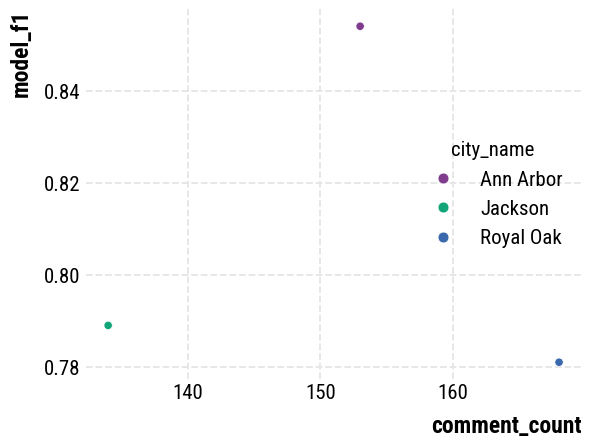

In [22]:
# LM plot with F1 of model + number of comments
_ = sns.lmplot(
    data=city_f1_entropy_df,
    x="comment_count",
    y="model_f1",
    hue="city_name",
)

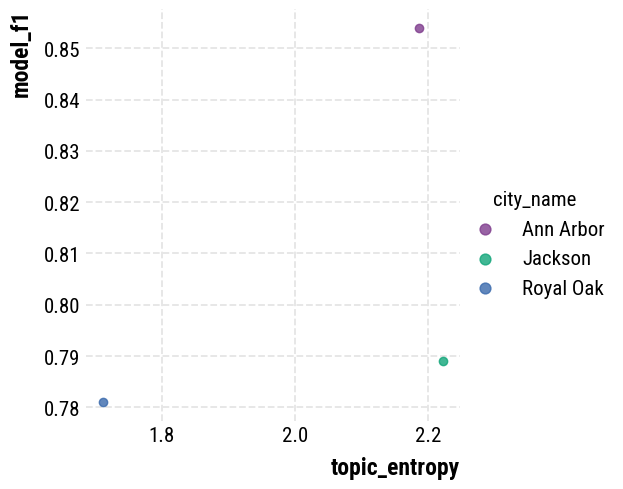

In [23]:
# LM plot with F1 and entropy
_ = sns.lmplot(
    data=city_f1_entropy_df,
    x="topic_entropy",
    y="model_f1",
    hue="city_name",
)